# daily KD code

## 1. Import package

In [1]:
import mysql.connector
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib
import secret as sc

## 2. 將資料從 MySQL 抓下來

In [2]:
def sqlquery(database, user, password):

    conn = None
    cursor = None
    column = ["trans_time", "open_price", "high_price", "low_price", "close_price"]
    df = pd.DataFrame(columns=column)
    try:
        #conn = mysql.connector.connect(database = 'iii_project', user='root', password='sc22805')
        conn = mysql.connector.connect(database = database, user=user, password=password)
        cursor = conn.cursor()

        sql = "SELECT * FROM eur_usd_4hr;"
        cursor.execute(sql)
        data_all = cursor.fetchall()
        for data in data_all:
            s = pd.Series(data, index=column)
            df = df.append(s, ignore_index=True)
        print(df.head(5))

    except mysql.connector.Error as err:
        print('err')

    finally:
        cursor.close()
        conn.close()
    
    return df

In [3]:
df = sqlquery(sc.database(), sc.user(), sc.password())

           trans_time open_price high_price low_price close_price
0 2000-05-30 16:00:00    0.93020    0.93050   0.92930     0.93050
1 2000-05-30 20:00:00    0.93060    0.93240   0.93060     0.93150
2 2000-05-31 00:00:00    0.93150    0.93220   0.92820     0.93000
3 2000-05-31 04:00:00    0.93020    0.93500   0.92900     0.92930
4 2000-05-31 08:00:00    0.92940    0.93650   0.92690     0.93340


## 3. 資料清理

### 3.1 將資料格式轉成 float64

In [4]:
df["open_price"] = df["open_price"].astype("float64")
df["high_price"] = df["high_price"].astype("float64")
df["low_price"] = df["low_price"].astype("float64")
df["close_price"] = df["close_price"].astype("float64")


### 3.2 清除離群值

In [5]:
def rpoutrange(df):
    dff = df
    colnm = ["open_price", "high_price", "low_price", "close_price"]
    for col in colnm:
        price_std = dff.describe()[col].loc["std"]
        price_mean = dff.describe()[col].loc["mean"]
        # 尋找離群值超過6個標準差的值
        flt_out = (dff[col] > price_mean + price_std*6) | (dff[col] < price_mean - price_std*6)
        flt_out_idx = dff[flt_out].index.values.astype(int)
        dff[col].iloc[flt_out_idx] = (dff[col].iloc[flt_out_idx+1].values + dff[col].iloc[flt_out_idx-1].values) / 2
    return dff

In [6]:
df = rpoutrange(df)
df.describe()

E:\Python\project_eur\venv\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,open_price,high_price,low_price,close_price
count,27700.000000,27700.000000,27700.000000,27700.000000
mean,1.228801,1.230904,1.226742,1.228810
std,0.166815,0.167034,0.166559,0.166804
min,0.823600,0.827900,0.822900,0.823500
25%,1.119300,1.121152,1.117545,1.119337
50%,1.261500,1.263900,1.258900,1.261500
75%,1.345900,1.347800,1.344100,1.345900
max,1.601000,1.604100,1.597700,1.601100


## 4. 將 4hr data 轉成 1day data

### 4.1 將時間取出萃取成一天

In [7]:
df["date"] = df["trans_time"].dt.date.astype(str)
df_day = df["date"].drop_duplicates().reset_index().drop(columns=["index"])
df_day

,date
0,2000-05-30
1,2000-05-31
2,2000-06-01
3,2000-06-02
4,2000-06-04
5,2000-06-05
6,2000-06-06
7,2000-06-07
8,2000-06-08
9,2000-06-09


### 4.2 定義 function 取每日的最高價、最低價、開盤價、收盤價

In [8]:
def high_d(df2, time):
    df_tmp = df2[df2["date"] == time].reset_index().drop(columns=["index", "trans_time"])
    return max(df_tmp["high_price"])

def low_d(df2, time):
    df_tmp = df2[df2["date"] == time].reset_index().drop(columns=["index", "trans_time"])
    return min(df_tmp["low_price"])

def open_d(df2, time):
    df_tmp = df2[df2["date"] == time].reset_index().drop(columns=["index", "trans_time"])
    open_price_d = df_tmp["open_price"].iloc[0]
    return open_price_d

def close_d(df2, time):
    df_tmp = df2[df2["date"] == time].reset_index().drop(columns=["index", "trans_time"])
    close_price_d = df_tmp["close_price"].iloc[len(df_tmp)-1]
    return close_price_d

### 4.3 計算每日data 放進 df_day 內

In [9]:
df_day["open_price"] = df_day["date"].apply(lambda x : open_d(df, x))
df_day["close_price"] = df_day["date"].apply(lambda x : close_d(df, x))
df_day["high_price"] = df_day["date"].apply(lambda x : high_d(df, x))
df_day["low_price"] = df_day["date"].apply(lambda x : low_d(df, x))

In [10]:
df_day

,date,open_price,close_price,high_price,low_price
0,2000-05-30,0.93020,0.93150,0.93240,0.92930
1,2000-05-31,0.93150,0.93770,0.93820,0.91510
2,2000-06-01,0.93760,0.93150,0.93800,0.92870
3,2000-06-02,0.93130,0.94400,0.94980,0.93080
4,2000-06-04,0.94610,0.94430,0.94640,0.94330
5,2000-06-05,0.94440,0.94630,0.94900,0.94160
6,2000-06-06,0.94620,0.95350,0.96030,0.94560
7,2000-06-07,0.95370,0.95960,0.96310,0.95370
8,2000-06-08,0.95940,0.95540,0.97040,0.95120
9,2000-06-09,0.95540,0.95480,0.95590,0.94630


## 5. 定義 rsv function，並計算出 rsv

In [11]:
def rsv(new_df):
    rsv = []
    for i in range(len(new_df)):
        if i < 8:
            rsv.append(0)
            # print(rsv)
        else:
            highp = []
            lowp = []
            for j in range(9):
                highp.append(new_df["high_price"].iloc[i-j])
                lowp.append(new_df["low_price"].iloc[i-j])
            high_max = max(highp)
            low_min = min(lowp)
            # print(new_df["close_price"].iloc[i],high_max,low_min)
            rsv_v = 100*(new_df["close_price"].iloc[i]-low_min)/(high_max-low_min)
            rsv.append(round(rsv_v,3))
            # print(rsv)
    return rsv

In [12]:
df_day["rsv"] = pd.Series(rsv(df_day))
df_day

,date,open_price,close_price,high_price,low_price,rsv
0,2000-05-30,0.93020,0.93150,0.93240,0.92930,0.000
1,2000-05-31,0.93150,0.93770,0.93820,0.91510,0.000
2,2000-06-01,0.93760,0.93150,0.93800,0.92870,0.000
3,2000-06-02,0.93130,0.94400,0.94980,0.93080,0.000
4,2000-06-04,0.94610,0.94430,0.94640,0.94330,0.000
5,2000-06-05,0.94440,0.94630,0.94900,0.94160,0.000
6,2000-06-06,0.94620,0.95350,0.96030,0.94560,0.000
7,2000-06-07,0.95370,0.95960,0.96310,0.95370,0.000
8,2000-06-08,0.95940,0.95540,0.97040,0.95120,72.875
9,2000-06-09,0.95540,0.95480,0.95590,0.94630,71.790


## 6. 定義 K/D 線 function，並算出 K/D 值

In [13]:
def k_lst(new_df):
    k_list = []
    for i in range(len(new_df)):
        if i == 0:
            k_list.append(0)
        else:
            k_value = (2/3) * k_list[i-1] + (1/3) * new_df["rsv"].iloc[i]
            k_list.append(round(k_value,3))
    return k_list

def d_lst(new_df):
    d_list = []
    for i in range(len(new_df)):
        if i == 0:
            d_list.append(0)
        else:
            d_value = (2/3) * d_list[i-1] + (1/3) * new_df["K_value"].iloc[i]
            d_list.append(round(d_value,3))
    return d_list

In [14]:
df_day["K_value"] = pd.Series(k_lst(df_day))
df_day["D_value"] = pd.Series(d_lst(df_day))
df_day

,date,open_price,close_price,high_price,low_price,rsv,K_value,D_value
0,2000-05-30,0.93020,0.93150,0.93240,0.92930,0.000,0.000,0.000
1,2000-05-31,0.93150,0.93770,0.93820,0.91510,0.000,0.000,0.000
2,2000-06-01,0.93760,0.93150,0.93800,0.92870,0.000,0.000,0.000
3,2000-06-02,0.93130,0.94400,0.94980,0.93080,0.000,0.000,0.000
4,2000-06-04,0.94610,0.94430,0.94640,0.94330,0.000,0.000,0.000
5,2000-06-05,0.94440,0.94630,0.94900,0.94160,0.000,0.000,0.000
6,2000-06-06,0.94620,0.95350,0.96030,0.94560,0.000,0.000,0.000
7,2000-06-07,0.95370,0.95960,0.96310,0.95370,0.000,0.000,0.000
8,2000-06-08,0.95940,0.95540,0.97040,0.95120,72.875,24.292,8.097
9,2000-06-09,0.95540,0.95480,0.95590,0.94630,71.790,40.125,18.773


## 7. 判斷 KD 值交叉時機

In [15]:
def kd_cross(new_df):
    new_df["K-D"] = new_df.K_value - new_df.D_value
    new_df["delt_K"] = new_df["K_value"] - new_df["K_value"].shift(1)
    k_boln_M = (new_df["K_value"] > 80) & (new_df["D_value"] > 80)
    k_boln_m = (new_df["K_value"] < 20) & (new_df["D_value"] < 20)
    kd_x = new_df["K-D"] * new_df["K-D"].shift(1) < 0
    selout = k_boln_m & kd_x
    buyin = k_boln_M & kd_x
    tradelen = len(new_df)
    trd = [0]
    for i in range(1,tradelen):
        trd.append(trd[i-1])
        if buyin[i] == True:
            trd[i] = 100
        elif selout[i] == True:
            trd[i] = 0
    new_df["KD_tunnel"] = pd.Series(trd)

In [16]:
kd_cross(df_day)
df_day

,date,open_price,close_price,high_price,low_price,rsv,K_value,D_value,K-D,delt_K,KD_tunnel
0,2000-05-30,0.93020,0.93150,0.93240,0.92930,0.000,0.000,0.000,0.000,NaN,0
1,2000-05-31,0.93150,0.93770,0.93820,0.91510,0.000,0.000,0.000,0.000,0.000,0
2,2000-06-01,0.93760,0.93150,0.93800,0.92870,0.000,0.000,0.000,0.000,0.000,0
3,2000-06-02,0.93130,0.94400,0.94980,0.93080,0.000,0.000,0.000,0.000,0.000,0
4,2000-06-04,0.94610,0.94430,0.94640,0.94330,0.000,0.000,0.000,0.000,0.000,0
5,2000-06-05,0.94440,0.94630,0.94900,0.94160,0.000,0.000,0.000,0.000,0.000,0
6,2000-06-06,0.94620,0.95350,0.96030,0.94560,0.000,0.000,0.000,0.000,0.000,0
7,2000-06-07,0.95370,0.95960,0.96310,0.95370,0.000,0.000,0.000,0.000,0.000,0
8,2000-06-08,0.95940,0.95540,0.97040,0.95120,72.875,24.292,8.097,16.195,24.292,0
9,2000-06-09,0.95540,0.95480,0.95590,0.94630,71.790,40.125,18.773,21.352,15.833,0


## 8. plotly 畫出圖

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

figdf2 = df_day
figdf2 = figdf2.set_index("date")
figdf2 = figdf2.loc["2016-01-01":"2017-02-30"]


# fig2 = go.Figure()
fig2 = make_subplots(specs=[[{"secondary_y": True}]])

fig2.add_trace(go.Scatter(
                x=figdf2.index,
                y=figdf2['K_value'],
                name="K_line",
                line_color='blue',
                opacity=0.3),
                secondary_y=False)

fig2.add_trace(go.Scatter(
                x=figdf2.index,
                y=figdf2['D_value'],
                name="D_line",
                line_color='red',
                opacity=0.3),
                secondary_y=False)

fig2.add_trace(go.Scatter(
                x = figdf2.index,
                y = [20]*len(figdf2),
                name="KD_lowb",
                line_color="black",
                opacity=0.5),
                secondary_y=False)

fig2.add_trace(go.Scatter(
                x = figdf2.index,
                y = [80]*len(figdf2),
                name="KD_upb",
                line_color="black",
                opacity=0.5),
                secondary_y=False)

fig2.add_trace(go.Scatter(
                x = figdf2.index,
                y=figdf2['KD_tunnel'],
                name="KD_buysell_tunnel",
                line_color="orange"),
                secondary_y=False)

fig2.add_trace(go.Candlestick(x=figdf2.index,
                open=figdf2['open_price'],
                high=figdf2['high_price'],
                low=figdf2['low_price'],
                close=figdf2['close_price'],
                name="K-line"),
                secondary_y=True)

# Use date string to set xaxis range
fig2.update_layout(title_text="Daily OHLC & KD trend chart", 
                   xaxis_rangeslider_visible=True)
fig2.show()

### 8.1 將 fig 轉成 img 輸出

- 需要 orca 軟體
    - Ref: https://github.com/plotly/orca

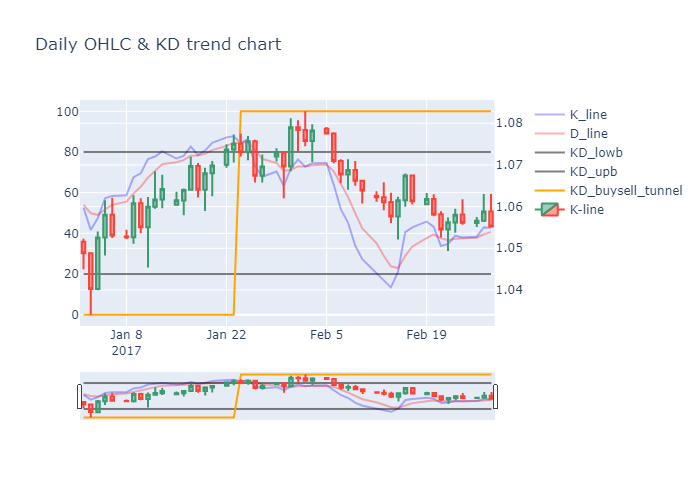

In [24]:
from IPython.display import Image
Image(fig2.to_image(format="png"))

### 8.2 將 fig 轉成 png 輸出

In [26]:
import os
import psutil, requests

if not os.path.exists("images"):
    os.mkdir("images")

fig2.write_image("images/fig1.png")